In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
plt.style.use(["science","no-latex", "/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle"])
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/")

# Load Dataset

In [2]:
from importlib import reload
import LoadMultiFiles
reload(LoadMultiFiles)
import FunctionFor_dE_dx
reload(FunctionFor_dE_dx)
from LoadMultiFiles import MultiFilesEvtIDMapProperty, LoadMultiFilesDataframe
from LoadMultiFiles import LoadOneFileUproot, LoadMultiROOTFiles
from FunctionFor_dE_dx import GetNPE, GetDirForNoOpticalAnalyze
from GetPhysicsProperty import NameToPDGID
from copy import copy
from HistTools import GetBinCenter
import tqdm

filter_leaves = ['xyz_center', 'step_x', 'step_y', 'step_z' ,'step_Edep', 'step_Equench',"step_dx",
                 "step_trackID" ]
max_PE_sum = 35000
max_dEdx = 50
bins_PE = np.linspace(0, max_PE_sum,200)
bins_dEdx = np.linspace(0, max_dEdx, 200)

dict_to_df = {"ion":[], "time":[], "chamberID":[], "BeamX":[], "BeamZ":[], "Ek":[], "dE_quench":[]}

save_to_fit = False
save_to_fit_contribution = False
plot_collect_eff = False

dict_nEvts = {}
# template_root_path = "/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/root2_addEvtIDinGen/{}_10cm_*.root"
template_root_path = "/afs/ihep.ac.cn/users/l/luoxj/junofs_500G/OneShotSimulation/root_particle_dependent/{}_10cm_*.root"
# template_root_path = "/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/root/hadd_{}_*.root"
v_particles = ["H_2","He_4",   "Li_6", "B_10", "C_12", "N_14","O_16", "F_18", "Ne_20", "Na_22"]
# v_particles = ["He_4",   "Li_6",  "C_12", "N_14","O_16", "F_18", "Ne_20", "Na_22"]
# v_particles = ["H_2","He_4",   "C_12", "O_16", "Ne_20"]
load_pkl = True
# v_particles = [ "H_2","Li_6",   "N_14","Na_22"]
if not load_pkl:
    dict_replace_chamberID = {i:f"{90-i*18} deg" for i in range(6)}
    for i,particle in tqdm.tqdm(enumerate(v_particles)):

        template_root_path_tmp = template_root_path

        dir_geninfo = LoadMultiROOTFiles(template_root_path_tmp.format(particle), name_branch="genInfo", use_multiprocess=False)
        dir_PMT_far = LoadMultiROOTFiles(template_root_path_tmp.format(particle), name_branch="PMT_log_R7600",  list_branch_filter=filter_leaves, use_multiprocess=False)
        dir_LS = LoadMultiROOTFiles(template_root_path_tmp.format(particle), name_branch="GdLS_log", use_multiprocess=False)

        pdgID_certain,dir_dEdx = GetDirForNoOpticalAnalyze(dir_events=dir_LS, dir_geninfo=dir_geninfo, pdgID=NameToPDGID(particle),
                                                           evtIDMap=True)
        v_dE_quench = MultiFilesEvtIDMapProperty( dir_PMT_far["evtID"], np.array(dir_PMT_far["LoadedFileNo"],dtype=int),
                                                 dir_dEdx["Equench"], dir_dEdx["evtID"], dir_dEdx["fileNo"])

        if "_addEvtIDinGen" in template_root_path_tmp or (particle == "H_2"):
            v_BeamXYZ = MultiFilesEvtIDMapProperty( dir_PMT_far["evtID"],np.array(dir_PMT_far["LoadedFileNo"],dtype=int),
                                            dir_geninfo["XYZ"],dir_geninfo["evtID"],
                                            np.array(dir_geninfo["LoadedFileNo"],dtype=int))
        else:
            v_BeamXYZ = np.zeros((len(dir_PMT_far["step_chamberID"]),3))

        v2d_BeamX = []
        v2d_BeamZ = []
        v2d_dE_quench = []
        for BeamXYZ, v_chamberID,dE_quench in  zip(v_BeamXYZ, dir_PMT_far["step_chamberID"],
                                                   v_dE_quench):
            v2d_BeamX.append( [BeamXYZ[0]]*len(v_chamberID))
            v2d_BeamZ.append( [BeamXYZ[2]]*len(v_chamberID))
            v2d_dE_quench.append( [dE_quench]*len(v_chamberID))

        dict_nEvts[particle] = len(dir_geninfo["E_init"])

        index_pdgID = np.concatenate(dir_PMT_far["step_pdgID"])==20022
        v_time =  np.concatenate(dir_PMT_far["step_t"])[index_pdgID]
        v_Ek = np.concatenate(dir_PMT_far["step_KineticE"])[index_pdgID]
        dict_to_df["time"] += list(v_time)
        dict_to_df["ion"]  += [particle]*len(v_time)
        dict_to_df["chamberID"] += list( np.concatenate(dir_PMT_far["step_chamberID"])[index_pdgID] )
        dict_to_df["BeamX"] += list( np.concatenate(v2d_BeamX) )
        dict_to_df["BeamZ"] += list( np.concatenate(v2d_BeamZ) )
        dict_to_df["Ek"] += list( v_Ek)
        dict_to_df["dE_quench"] += list( np.concatenate(v2d_dE_quench) )

    for key, items in dict_to_df.items():
        print(key, len(items))
    df_time = pd.DataFrame.from_dict(dict_to_df)
    dict_to_df.clear()
    df_time["theta"] = df_time["chamberID"].replace(dict_replace_chamberID)

    # Binning BeamX
    bins_BeamXZ = np.linspace(-25,25, 6)
    df_time["bin_BeamX"] = pd.cut( df_time["BeamX"], bins_BeamXZ)
    df_time["bin_BeamZ"] = pd.cut( df_time["BeamZ"], bins_BeamXZ)
else:
    # df_time = pd.read_pickle("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/particle_time_profile_data2.pkl")
    df_time = LoadMultiFilesDataframe("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/pkl/PMT_far_*.pkl")
df_time


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [05:12<00:00,  5.21s/it]


,index,ion,time,chamberID,BeamX,BeamZ,Ek,dE_quench,dE/dx,parentPDGID,parent_dEdx,theta,isCherenkov
0,0,Na_22,7.663753,10,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.169162,58.893853,0
1,1,Na_22,17.582834,2,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.169162,58.862990,0
2,2,Na_22,13.655207,4,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.169162,30.803461,0
3,3,Na_22,5.660405,7,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.168839,15.711523,0
4,4,Na_22,10.175151,3,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.242983,45.174791,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73604275,1826113,Li_6,42.898828,3,-20.215388,-10.077754,0.000003,5.291415,2.913300,11,0.468748,46.596377,0
73604276,1826114,Li_6,5.216373,12,-20.215388,-10.077754,0.000003,5.291415,2.913300,1000030060,2.825607,91.927486,0
73604277,1826115,Li_6,7.314854,12,-20.215388,-10.077754,0.000003,5.291415,2.913300,1000030060,2.825607,91.098517,0
73604278,1826116,Li_6,4.589395,8,-20.215388,-10.077754,0.000003,5.291415,2.913300,1000030060,2.825607,31.472388,0


In [3]:
if load_pkl:
    dict_replace_chamberID = {}
    dict_replace_chamberID_int = {}
    df_to_extract_theta = df_time[:10000]
    for chamberID in set(df_to_extract_theta["chamberID"]):
        theta_mean = np.round( np.mean(df_to_extract_theta[df_to_extract_theta["chamberID"]==chamberID]["theta"]),0)
        dict_replace_chamberID[chamberID] = f"{theta_mean:.0f} deg"
        dict_replace_chamberID_int[chamberID] = int(theta_mean)


    df_time["mean_theta"] = df_time["chamberID"].replace( dict_replace_chamberID )
    df_time["mean_theta_int"] = df_time["chamberID"].replace( dict_replace_chamberID_int )

    # Binning BeamX
    # df_time.drop(["bin_BeamX", "bin_BeamZ"], axis=1)
    # bins_BeamXZ = np.arange(-25,25, 10)
    bins_BeamXZ = np.linspace(-25,25, 6)
    df_time["bin_BeamX"] = pd.cut( df_time["BeamX"], bins_BeamXZ)
    df_time["bin_BeamZ"] = pd.cut( df_time["BeamZ"], bins_BeamXZ)

In [4]:
df_time

,index,ion,time,chamberID,BeamX,BeamZ,Ek,dE_quench,dE/dx,parentPDGID,parent_dEdx,theta,isCherenkov,mean_theta,mean_theta_int,bin_BeamX,bin_BeamZ
0,0,Na_22,7.663753,10,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.169162,58.893853,0,60 deg,60,"(-25.0, -15.0]","(5.0, 15.0]"
1,1,Na_22,17.582834,2,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.169162,58.862990,0,60 deg,60,"(-25.0, -15.0]","(5.0, 15.0]"
2,2,Na_22,13.655207,4,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.169162,30.803461,0,30 deg,30,"(-25.0, -15.0]","(5.0, 15.0]"
3,3,Na_22,5.660405,7,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.168839,15.711523,0,15 deg,15,"(-25.0, -15.0]","(5.0, 15.0]"
4,4,Na_22,10.175151,3,-23.398283,6.440078,0.000003,41.121071,42.504567,11,0.242983,45.174791,0,45 deg,45,"(-25.0, -15.0]","(5.0, 15.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73604275,1826113,Li_6,42.898828,3,-20.215388,-10.077754,0.000003,5.291415,2.913300,11,0.468748,46.596377,0,45 deg,45,"(-25.0, -15.0]","(-15.0, -5.0]"
73604276,1826114,Li_6,5.216373,12,-20.215388,-10.077754,0.000003,5.291415,2.913300,1000030060,2.825607,91.927486,0,90 deg,90,"(-25.0, -15.0]","(-15.0, -5.0]"
73604277,1826115,Li_6,7.314854,12,-20.215388,-10.077754,0.000003,5.291415,2.913300,1000030060,2.825607,91.098517,0,90 deg,90,"(-25.0, -15.0]","(-15.0, -5.0]"
73604278,1826116,Li_6,4.589395,8,-20.215388,-10.077754,0.000003,5.291415,2.913300,1000030060,2.825607,31.472388,0,30 deg,30,"(-25.0, -15.0]","(-15.0, -5.0]"


In [5]:
# df_time_tmp = pd.read_pickle("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/particle_time_profile_data.pkl")
# df_time_concat = pd.concat((df_time_tmp,df_time))
# pd.to_pickle(df_time_concat,"/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/particle_time_profile_data2.pkl")

# df_time =

In [6]:
bins_time_profile = np.array([-20, -17, -14, -11, -8, -5, -2, 1, 4, 7, 10, 13, 16, 19, 22, 28, 34, 40, 46, 52, 58, 64, 72, 80, 90, 102, 116, 132, 150, 170, 192, 216, 242, 270, 300, 332, 366, 402, 440, 480, 522, 566, 612, 660, 710, 762,816, 872,930,990])+19

# $\theta$ Dependence
## 1. Time Profile

/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarning: invalid value encountered in true_divide
  ratio_error = np.sqrt( (hist_base**2*h_error**2 + h[0]**2*hist_base_error**2)/hist_base**4 )
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:157: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(bin_center, (h[0]-hist_base)/hist_base,xerr=np.diff(h[1])/2,yerr=ratio_error,color=color,
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarning: invalid value encountered in true_divide
  ratio_error = np.sqrt( (hist_base**2*h_error**2 + h[0]**2*hist_base_error**2)/hist_base**4 )
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:157: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(bin_center, (h[0]-hist_base)/hist_base,xerr=np.diff(h[1])/2,yerr=ratio_error,color=color,
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarni

45 deg    1015022
60 deg     994340
30 deg     945362
75 deg     918534
15 deg     799879
90 deg     673016
1 deg      320629
Name: mean_theta, dtype: int64

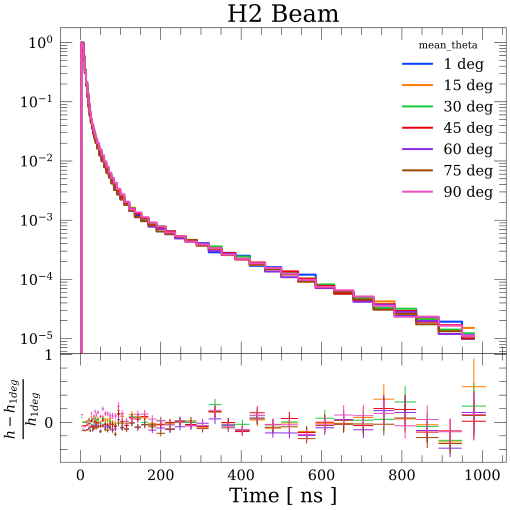

In [7]:
from PlotTools import AutoGetColorWithALotOfLine
import  HistTools
reload(HistTools)
from HistTools import DfHistPlotNormByMax, PlotHistNormByMax
v_theta_order = sorted(set(dict_replace_chamberID.values()))
ax0, ax1 = DfHistPlotNormByMax( data=df_time[df_time["ion"]=="H_2"], x="time", hue="mean_theta",
                     bins=bins_time_profile,divide_binWidth=True, hue_order= v_theta_order)
ax1.set_xlabel("Time [ ns ]")
ax0.set_title("H2 Beam")
ax0.semilogy()
# ax1.set_ylim(-0.2,0.5)
df_time[ (df_time["ion"]=="H_2")]["mean_theta"].value_counts()

In [8]:
if save_to_fit:
    import ROOT
    dir_save = {"time":[], "theta":[], "N_nuclei":[]}
    for particle in tqdm.tqdm(["H_2", "C_12", "Ne_20"]):
        for theta in v_theta_order:
            df_tmp = df_time[(df_time["ion"]==particle)&(df_time["mean_theta"]==theta)]
            # plt.figure()
            # h = plt.hist(df_tmp["time"], bins=np.linspace(-10, 30,500),
            #              histtype="step", label=theta)
            h = np.histogram(df_tmp["time"], bins=np.linspace(-10, 30,500))
            dir_save["time"] += list( np.array(df_tmp["time"])-GetBinCenter(h[1])[np.argmax(h[0])] )
            dir_save["theta"] += list( np.array(df_tmp["mean_theta_int"]))
            dir_save["N_nuclei"] += [int(particle.split("_")[1])]*len(df_tmp["mean_theta_int"])
    for key in dir_save.keys():
        dir_save[key] = np.array(dir_save[key])
    rdf = ROOT.RDF.MakeNumpyDataFrame(dir_save)
    rdf.Snapshot("Data", f"/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/theta_dependent/time_particle_subset.root" )
    dir_save.clear()


## 2. Collect Efficiency

In [13]:
if plot_collect_eff:
    from LoadMultiFiles import LoadMultiFileUprootMultiBranch
    v_files = []
    file_template = "root://junoeos01.ihep.ac.cn//eos/juno/user/luoxj/JUNO_G4_Simulation/OneShotSimulation/root2_addEvtIDinGen_calib/H_2_10cm_{}.root"
    for fileNo in range(3001, 3600+1):
        v_files.append(file_template.format(fileNo))
    dict_MultiBranches = LoadMultiFileUprootMultiBranch(v_files, v_name_branch=["genInfo"],
                                                            templateToExtractFileNo=file_template.replace("{}", "(.*)"))

439it [05:02,  1.45it/s]


KeyboardInterrupt: 

/cvmfs/juno.ihep.ac.cn/sw/anaconda/Anaconda3-2020.11-Linux-x86_64/envs/root624/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


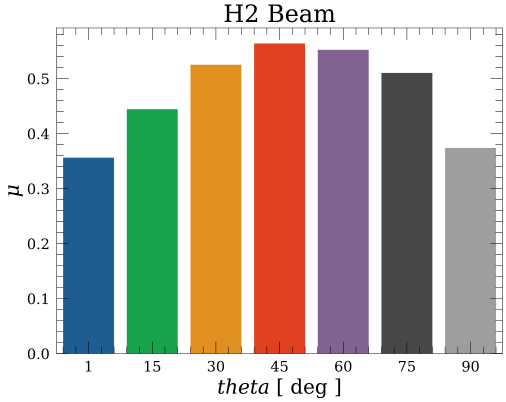

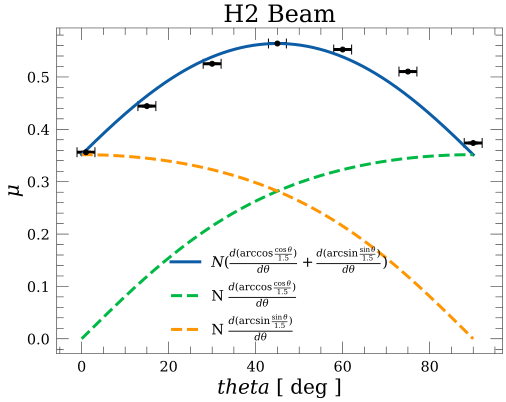

In [58]:
if True:
    n_Evts_total = 1500*600
    # sns.countplot(data=df_time[df_time["ion"]=="H_2"], x="theta", order=dict_replace_chamberID.values(),
    #               estimator=lambda x: len(x) / n_Evts_total * 100)
    df_count = df_time[df_time["ion"]=="H_2"].value_counts("mean_theta_int")

    # theta = 0 degs only have one PMT
    df_count[1] = df_count[1]*2
    df_count /= 2

    v_yerr = 1/np.array(df_count **0.5)
    df_count /= n_Evts_total

    sns.barplot(df_count.index, df_count)
    plt.ylabel("$\mu$")
    plt.xlabel("$theta$ [ deg ]")
    plt.title("H2 Beam")

    plt.figure()
    plt.errorbar(df_count.index,df_count,yerr=v_yerr, xerr=2.06,ls="none",
             marker="o", capsize=5, capthick=1,color="black",
             markersize=5)

    from HistTools import GetBinCenter
    theta2 = np.linspace(0, np.pi/2, 10000)
    theta2_center = GetBinCenter(theta2)
    theta1 = np.arccos( np.cos(theta2)/1.5 )
    theta1_add = np.arcsin( np.sin(theta2)/1.5 )
    v_theta_range = np.degrees(np.diff(theta1_add))+np.degrees(np.diff(theta1))
    plt.plot(np.degrees(theta2_center), v_theta_range/max(v_theta_range)*df_count.max(),
             label=r"$N (\frac{d(\arccos{ \frac{ \cos{\theta} }{1.5} )}}{d\theta}+\frac{d(\arcsin{ \frac{ \sin{\theta} }{1.5} )}}{d\theta})$")
    plt.plot(np.degrees(theta2_center), np.degrees(np.diff(theta1))/max(v_theta_range)*df_count.max(), ls="--",
             label=r"N $\frac{d(\arccos{ \frac{ \cos{\theta} }{1.5} )}}{d\theta}$")
    plt.plot(np.degrees(theta2_center), np.degrees(np.diff(theta1_add))/max(v_theta_range)*df_count.max() ,ls="--",
             label=r"N $\frac{d(\arcsin{ \frac{ \sin{\theta} }{1.5} )}}{d\theta}$")
    plt.ylabel("$\mu$")
    plt.xlabel("$theta$ [ deg ]")
    plt.title("H2 Beam")
    plt.legend()

# dE/dx Dependence
## 1. Without dE Measurement

/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarning: invalid value encountered in true_divide
  ratio_error = np.sqrt( (hist_base**2*h_error**2 + h[0]**2*hist_base_error**2)/hist_base**4 )
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:157: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(bin_center, (h[0]-hist_base)/hist_base,xerr=np.diff(h[1])/2,yerr=ratio_error,color=color,
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarning: invalid value encountered in true_divide
  ratio_error = np.sqrt( (hist_base**2*h_error**2 + h[0]**2*hist_base_error**2)/hist_base**4 )
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:157: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(bin_center, (h[0]-hist_base)/hist_base,xerr=np.diff(h[1])/2,yerr=ratio_error,color=color,
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarni

,Ion,nEvts
0,H_2,336109
1,He_4,643979
2,Li_6,651677
3,B_10,1171738
4,C_12,262689
5,N_14,332638
6,O_16,195299
7,F_18,228432
8,Ne_20,259622
9,Na_22,290072


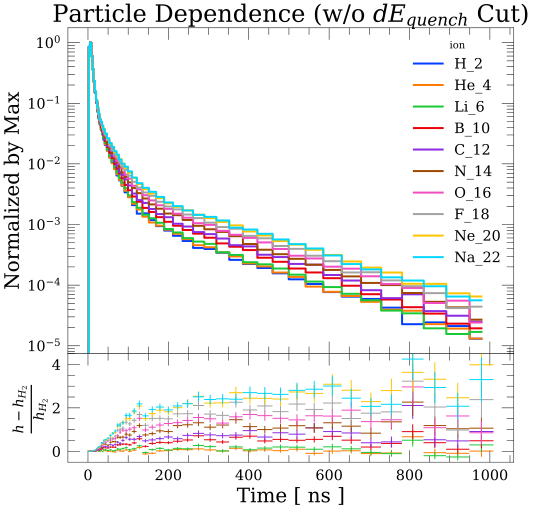

In [10]:
dict_evt_to_df = {"Ion":[], "nEvts":[]}
dict_hist = {}
dict_bins_center = {}
chamberID = 0

ax0, ax1 = DfHistPlotNormByMax(df_time[df_time["chamberID"]==chamberID], x="time", hue="ion",
                    divide_binWidth=True,bins=bins_time_profile, hue_order=v_particles)
ax0.semilogy()
ax1.set_xlabel("Time [ ns ]")
ax0.set_title("Particle Dependence (w/o $dE_{quench}$ Cut)")
ax0.set_ylabel("Normalized by Max")
ax1.set_ylim(-0.5,4.5)
# ax1.set_ylim(-0.5,0.5)
for i,particle in enumerate(v_particles):
    dict_evt_to_df["Ion"].append(particle)
    dict_evt_to_df["nEvts"].append(len(df_time[(df_time["chamberID"]==chamberID)& (df_time["ion"]==particle)]["time"]))
pd.DataFrame.from_dict(dict_evt_to_df)

## 2. With $dE_{quench}$

In [11]:
from lmfit.models import GaussianModel
from HistTools import GetBinCenter
bins_dE_quench = np.concatenate((np.linspace(0,10,1000), np.linspace(10,50, 200)))
sns.histplot(data=df_time, x="dE_quench", hue="ion", bins=bins_dE_quench, palette="bright",
             hue_order=v_particles)
v_colors = sns.color_palette("bright")[:len(v_particles)]
dict_dE_quench_range = {}
for i,particle in enumerate(v_particles):
    mod = GaussianModel()
    hist = np.histogram(df_time[df_time["ion"]==particle]["dE_quench"], bins=bins_dE_quench)

    pars = mod.guess(hist[0], x=GetBinCenter(hist[1]))
    out = mod.fit(hist[0], pars, x=GetBinCenter(hist[1]))
    # print(out.fit_report(min_correl=0.25))
    plt.plot( GetBinCenter(hist[1]), out.best_fit,color=v_colors[i], linewidth=1)
    center = out.params["center"].value
    fwhm = out.params["fwhm"].value
    sigma = out.params["sigma"].value
    dict_dE_quench_range[particle] = (center-sigma, center+sigma)
    plt.axvspan(dict_dE_quench_range[particle][0], dict_dE_quench_range[particle][1] ,facecolor=v_colors[i], alpha=0.2)
plt.xlabel("$dE_{quench}$ [ MeV ]")
plt.title("$dE_{quench}$ Cut (1$\sigma$)")


KeyboardInterrupt: 

In [ ]:
print(dict_dE_quench_range)


In [ ]:
np.savez("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/dE_xErr.root", dE_quench=dict_dE_quench_range)

In [ ]:
dict_evt_to_df = {"Ion":[], "nEvts":[]}
# f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]},
#                              sharex=True, figsize=(8,8))

hist_base = None
bin_center = None
v_colors = sns.color_palette("bright")[:len(v_particles)]
for i, particle in enumerate(v_particles):
    series_time = df_time[(df_time["chamberID"]==chamberID)& (df_time["ion"]==particle) &
                              (df_time["dE_quench"]>dict_dE_quench_range[particle][0]) &
                              (df_time["dE_quench"]<dict_dE_quench_range[particle][1]) ]["time"]
    dict_evt_to_df["Ion"].append(particle)
    dict_evt_to_df["nEvts"].append(len(series_time))
ax0, ax1 = DfHistPlotNormByMax(df_time[df_time["chamberID"]==chamberID], x="time", hue="ion",
                    divide_binWidth=True,bins=bins_time_profile, hue_order=v_particles,
                               key_cut="dE_quench", dict_cut_for_df=dict_dE_quench_range)
ax0.semilogy()
ax1.set_xlabel("Time [ ns ]")
ax1.set_ylim(-0.5,4.5)
ax1.set_ylabel(r"$\frac{h_{ion}-h_{H2}}{h_{H2}}$")
ax0.set_title("Particle Dependence (w/ $dE_{quench}$ Cut)")
ax0.legend()
pd.DataFrame.from_dict(dict_evt_to_df)

## 3. Time Profiles of Different dE slice (Same Particle)

In [ ]:
reload(HistTools)
from HistTools import DfHistPlotNormByMax
for particle in ["B_10", "N_14"]:
# for particle in ["N_14"]:
    df_oneIon = df_time[(df_time["ion"]==particle)&(df_time["mean_theta"]=="90 deg")]
    center_dE_quench = np.mean(dict_dE_quench_range[particle])
    sigma_dE_quench = dict_dE_quench_range[particle][1]-center_dE_quench
    print(center_dE_quench, sigma_dE_quench)
    df_oneIon["bin_dE_quench"] = pd.cut(df_oneIon["dE_quench"],
                                        bins=np.round(np.linspace(center_dE_quench-sigma_dE_quench*3, center_dE_quench+sigma_dE_quench*3, 7),1))
    display( df_oneIon.value_counts("bin_dE_quench") )
    df_oneIon.dropna(inplace=True)

    ax0, ax1 = DfHistPlotNormByMax(df_oneIon, x="time", hue="bin_dE_quench",
                                    divide_binWidth=True,bins=bins_time_profile,
                                   hue_order=sorted(set(df_oneIon["bin_dE_quench"])),
                                   ratio_base=df_oneIon.value_counts("bin_dE_quench").idxmax())
    ax0.semilogy()
    ax1.set_xlabel("Time [ ns ]")
    ax0.set_title(particle)
    ax0.set_ylabel("Normalized by Max")
    ax1.set_ylim(-0.5,0.5)

# Beam Span
## 1. Time Profile

In [ ]:
ax0, ax1 = DfHistPlotNormByMax(df_time[(df_time["chamberID"]==0) & (df_time["ion"]=="B_10")], x="time", hue="bin_BeamZ",
                    divide_binWidth=True,bins=bins_time_profile)
ax0.semilogy()
ax1.set_xlabel("Time [ ns ]")
ax0.set_title("Beam Span Effect")
ax0.set_ylabel("Normalized by Max")
ax1.set_ylim(-0.5,0.5)


## 2. Photon Wavelength Distribution

In [ ]:
from GetPhysicsProperty import PhotonEkToWavelength
df_time["wavelength"] = PhotonEkToWavelength(df_time["Ek"]*1e6)

In [ ]:
v_QE_energy_R7600 = np.array([1.44748006676891, 1.45642080404452, 1.4632132762312637, 1.4723532162180213, 1.4792826572163997, 1.488615365846751, 1.5027976749454033, 1.5172561871899748, 1.5270757816166447, 1.5420040709666063, 1.5572235629787123, 1.5727392411123233, 1.5885782966713626, 1.6101697071950005, 1.6379750415893604, 1.660931727141913, 1.690525623073383, 1.7274371854215067, 1.7791980961357698, 1.8341518276545148, 1.8925822319222718, 1.9629501104539095, 2.047476163936981, 2.1396360880878493, 2.235214110242814, 2.3455047849189246, 2.493106492899987, 2.6383747823300245, 2.80159652978221, 2.9863322494930427, 3.218716320608959, 3.5030944007546334, 3.8117691028973706, 4.198487287562826, 4.538376116627369])
v_QE_R7600 = np.array([0.00011368686912342797, 0.0001586927561872007, 0.00021590457169124548, 0.00030526686436940125, 0.000394548392742065, 0.0005367907382360723, 0.0007303142072217293, 0.0010064344990663328, 0.0013692736497681142, 0.0018629233493969476, 0.002502238435750439, 0.0032758222942595905, 0.004456819746355836, 0.0060635896783274275, 0.008249631324484658, 0.01093949349783117, 0.014506408017762658, 0.018991161719551026, 0.024545514785012244, 0.03131999809853483, 0.03748143035865177, 0.04782618485883798, 0.05507405769569692, 0.06675941691144277, 0.07989267521275802, 0.09684393407453135, 0.11890740838088303, 0.14048576217304581, 0.16177583460146103, 0.1839178813566959, 0.19863242251507265, 0.20379437867685632, 0.20379437867685674, 0.19863242251507265, 0.15971386457872036])
v_QE_wavelength_R7600 = PhotonEkToWavelength(v_QE_energy_R7600)

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8,8),gridspec_kw={'height_ratios': [2, 1]} )
plt.subplots_adjust(wspace=0, hspace=0)
sns.histplot(data=df_time[(df_time["chamberID"]==0) & (df_time["ion"]=="H_2")], x="wavelength", hue="bin_BeamZ", stat="probability", bins=np.linspace(300,600,50),fill=False,element="step",palette="bright", common_norm=False, ax=axes[0])
axes[1].plot(v_QE_wavelength_R7600, v_QE_R7600, label="R7600U QE")
axes[1].set_xlabel("Wavelength [ nm ]")
axes[0].set_title("Beam Span Effect")
axes[1].set_ylabel("QE")
axes[1].legend()

In [ ]:
# df_time.to_pickle("/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/particle_time_profile_data_particle_dependent.pkl")

# Contribution of Different Parent for Time Profile
## 1. Time Profile

/tmp/ipykernel_16752/3356792513.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oneIon["parentType"] = df_oneIon["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, pdgID_main_track))


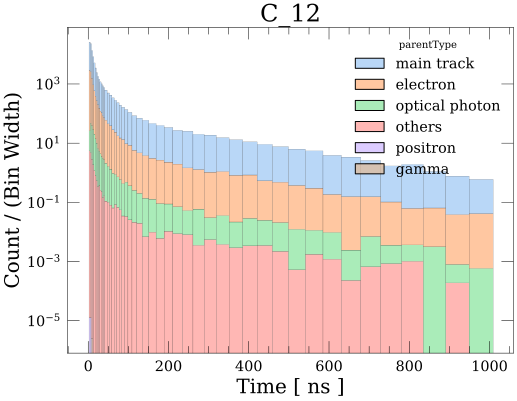

In [63]:
def tag_parentType(pdgID, pdgID_main_track):
    # if pdgID in [22, 11,-11]:
    #     return "electron"
    if pdgID == 11:
        return "electron"
    elif pdgID == 22:
        return "gamma"
    elif pdgID == -11:
        return "positron"
    elif pdgID == 20022:
        return "optical photon"
    elif pdgID == pdgID_main_track:
        return "main track"
    else:
        return "others"
for particle in ["C_12"]:
    plt.figure()
    pdgID_main_track = NameToPDGID(particle)
    df_oneIon = df_time[(df_time["ion"]==particle)&(df_time["mean_theta"]=="90 deg")]
    df_oneIon["parentType"] = df_oneIon["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, pdgID_main_track))
    count = df_oneIon.value_counts("parentType")
    hue_order = [item[1] for item in sorted(zip( count,count.index),reverse=True)]
    sns.histplot(data=df_oneIon,x="time",bins=bins_time_profile, stat="frequency",
                 multiple="stack",hue="parentType",kde=False,
                    palette="pastel",hue_order=hue_order)
    plt.semilogy()
    plt.xlabel("Time [ ns ]")
    plt.ylabel("Count / (Bin Width)")
    plt.title(particle)

/tmp/ipykernel_16752/1949786728.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oneIon["parentType"] = df_oneIon["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, pdgID_main_track))
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarning: invalid value encountered in true_divide
  ratio_error = np.sqrt( (hist_base**2*h_error**2 + h[0]**2*hist_base_error**2)/hist_base**4 )
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:157: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(bin_center, (h[0]-hist_base)/hist_base,xerr=np.diff(h[1])/2,yerr=ratio_error,color=color,
/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/HistTools.py:156: RuntimeWarning: invalid value 

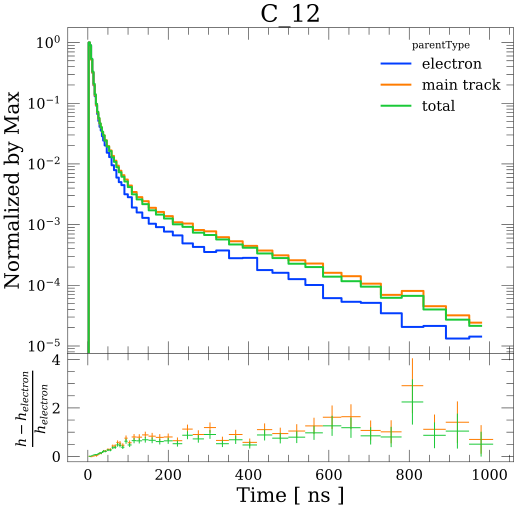

In [69]:
from copy import copy
for particle in ["C_12"]:

    pdgID_main_track = NameToPDGID(particle)
    df_oneIon = df_time[(df_time["ion"]==particle)&(df_time["mean_theta"]=="90 deg")]
    df_oneIon["parentType"] = df_oneIon["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, pdgID_main_track))
    df_oneIon_total = copy(df_oneIon)
    df_oneIon_total["parentType"] = "total"
    df_oneIon = pd.concat((df_oneIon, df_oneIon_total))
    ax0, ax1 = DfHistPlotNormByMax(df_oneIon,x="time", hue="parentType",divide_binWidth=True,bins=bins_time_profile,
                                    hue_order=["electron", "main track", "total"])
    ax0.semilogy()
    ax1.set_xlabel("Time [ ns ]")
    ax0.set_ylabel("Normalized by Max")
    ax0.set_title(particle)


## 2. Plot Hits Count Contribution from Different Parent Type

In [ ]:
df_daughter_contribution = pd.DataFrame()
for particle in v_particles:
    pdgID_main_track = NameToPDGID(particle)
    df_oneIon = df_time[(df_time["ion"]==particle)&(df_time["mean_theta"]=="90 deg")]
    df_oneIon["parentType"] = df_oneIon["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, pdgID_main_track))
    count = df_oneIon.value_counts("parentType", normalize=True)
    df_daughter_contribution = pd.concat((df_daughter_contribution, count), axis=1).rename(columns={0:particle })
del df_oneIon
df_daughter_contribution.fillna(0)

In [ ]:
df_daughter_contribution.T.plot.bar(rot=45)
plt.ylabel("Percentage of Photon Source")
plt.legend(bbox_to_anchor=(1,1))
plt.title("Contribution from Parent Particle")

In [ ]:
sns.histplot(data=df_time[(df_time["mean_theta"]=="90 deg")], x="parent_dEdx",bins=np.linspace(0,100, 200),
             hue="ion",fill=False, element="step", palette="bright", stat="probability", hue_order=v_particles)
plt.xlim(0, 100)
plt.semilogy()
plt.xlabel("dE/dx [ MeV/mm ]")
plt.title("dE/dx of Photon Parent Particle")

In [ ]:
particle = "O_16"
df_tmp = df_time[(df_time["mean_theta"]=="90 deg") & (df_time["ion"]==particle)]
df_tmp["parentType"] = df_tmp["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, NameToPDGID(particle)))
sns.histplot(data=df_tmp, x="parent_dEdx",bins=np.linspace(0,100, 200),multiple="stack",
             hue="parentType",  palette="bright", stat="probability")
plt.xlim(0, 100)
plt.semilogy()
plt.xlabel("dE/dx [ MeV/mm ]")
plt.title(particle)

In [64]:
# save_to_fit_contribution = True
if save_to_fit_contribution:
    theta_save = 15
    dict_replace_sourceTag = {"main track":0, "electron":1,"others":2, "optical photon":3,"gamma":4, "positron":5}
    dir_save = {"time":[], "source":[], "N_nuclei":[]}
    for particle in tqdm.tqdm(v_particles):
        for theta in [f"{theta_save} deg"]:
            df_tmp = df_time[(df_time["ion"]==particle)&(df_time["mean_theta"]==theta)]
            h = np.histogram(df_tmp["time"], bins=np.linspace(-10, 30,500))

            df_tmp["parentType"] = df_tmp["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, NameToPDGID(particle)))

            dir_save["time"] += list( np.array(df_tmp["time"])-GetBinCenter(h[1])[np.argmax(h[0])] )
            dir_save["N_nuclei"] += [int(particle.split("_")[1])]*len(df_tmp["mean_theta_int"])
            dir_save["source"] += list( np.array(df_tmp["parentType"].replace(dict_replace_sourceTag)) )

    for key in dir_save.keys():
        dir_save[key] = np.array(dir_save[key])

    import ROOT
    rdf = ROOT.RDF.MakeNumpyDataFrame(dir_save)
    rdf.Snapshot("Data", f"/afs/ihep.ac.cn/users/l/luoxj/JUNO_G4_Simulation/optical_run/OneShotSimulation/daughter_contribution/time_particle_theta{theta_save}.root" )
    dir_save.clear()

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_16752/508467562.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["parentType"] = df_tmp["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, NameToPDGID(particle)))
 10%|████████▍                                                                           | 1/10 [01:01<09:12, 61.36s/it]/tmp/ipykernel_16752/508467562.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

OBJ: TStyle	dybStyle	Daya Bay Style : 0 at: 0x55939671b910
Welcome to JupyROOT 6.24/00


# Study Time Profile Rising Edge

In [ ]:
v_theta = sorted( set(df_time["mean_theta"][:200]) )
for particle in v_particles[:1]:
    for theta in v_theta:
        plt.hist(df_time[(df_time["ion"]==particle) & (df_time["mean_theta"]==theta)]["time"],
                 bins=np.linspace(0, 20, 100), histtype="step", density=True, label=theta)
plt.xlabel("Time [ ns ]")
plt.title(r"Rising Edge at Different $\theta$")
plt.legend()

isCherenkov
0    318574
1      2055
dtype: int64

isCherenkov
0    672951
1        65
dtype: int64

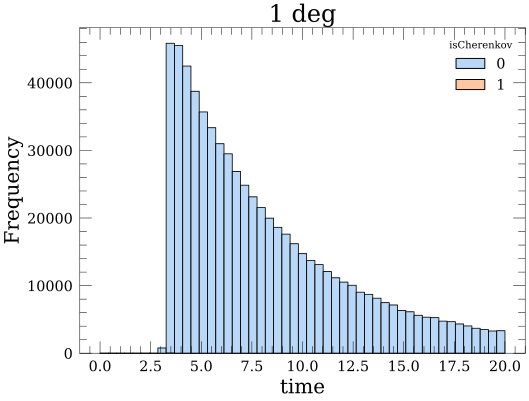

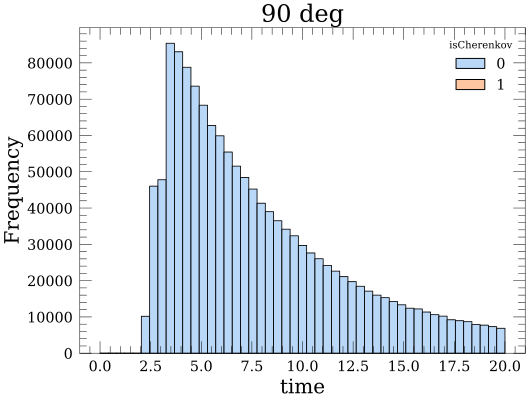

In [61]:
for particle in v_particles[:1]:
    for theta in ["1 deg", "90 deg"]:
        plt.figure()
        sns.histplot(data=df_time[(df_time["ion"]==particle) & (df_time["mean_theta"]==theta)],
                     x="time",bins=np.linspace(0, 20, 50), stat="frequency",
                    multiple="stack",hue="isCherenkov",kde=False,
                    palette="pastel")
        plt.title(theta)
        display( df_time[(df_time["ion"]==particle) & (df_time["mean_theta"]==theta)].value_counts("isCherenkov") )

In [ ]:
for particle in v_particles[:1]:
    for theta in ["1 deg", "90 deg"]:
        plt.figure()
        pdgID_main_track = NameToPDGID(particle)
        df_oneIon = df_time[(df_time["ion"]==particle) & (df_time["mean_theta"]==theta)]
        df_oneIon["parentType"] = df_oneIon["parentPDGID"].apply(lambda pdgID: tag_parentType(pdgID, pdgID_main_track))
        sns.histplot(data=df_oneIon,
                     x="time",bins=np.linspace(0, 20, 50), stat="frequency",
                    multiple="stack",hue="parentType",kde=False,
                    palette="pastel")
        plt.title(theta)

In [ ]:
from matplotlib.colors import LogNorm
for particle in v_particles[:1]:
    for theta in ["1 deg", "90 deg"]:
        plt.figure()
        df_oneIon = df_time[(df_time["ion"]==particle) & (df_time["mean_theta"]==theta)]
        plt.hist2d(df_oneIon["time"], df_oneIon["wavelength"], bins=(np.linspace(0, 20, 50), np.linspace(350,550,100)),cmap="Blues",
                   norm=LogNorm())


In [ ]:
for particle in v_particles[:1]:
    for theta in ["60 deg", "90 deg"]:
        df_oneIon = df_time[(df_time["ion"]==particle) & (df_time["mean_theta"]==theta)]
        print(len(df_oneIon))
        display( df_oneIon.value_counts("bin_BeamZ") )